# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [8]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [9]:
#!pip install -qU qdrant-client

In [10]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bsmith53\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bsmith53\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

We'll also provide our OpenAI key, as well as our Cohere API key.

In [11]:
import os
import getpass



In [12]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key: ")
os.environ["LANGSMITH_PROJECT"] = "ASSIGNMENT_13"
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [13]:
!mkdir data

A subdirectory or file data already exists.


In [14]:
!curl https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -o data/john_wick_1.csv
!curl https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -o data/john_wick_2.csv
!curl https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -o data/john_wick_3.csv
!curl https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -o data/john_wick_4.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19628  100 19628    0     0  69856      0 --:--:-- --:--:-- --:--:-- 70351
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14747  100 14747    0     0  67752      0 --:--:-- --:--:-- --:--:-- 68590
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13888  100 13888    0     0  60014      0 --:--:-- --:--:-- --:--:-- 60646
  % Total    % Received % Xferd  Average Speed   

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [15]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"data/john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [16]:
documents[0]

Document(metadata={'source': 'data/john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 17, 13, 36, 56, 113260)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

In [17]:
chunkSizes = []
for doc in documents:
    chunkSizes.append(len(doc.page_content))

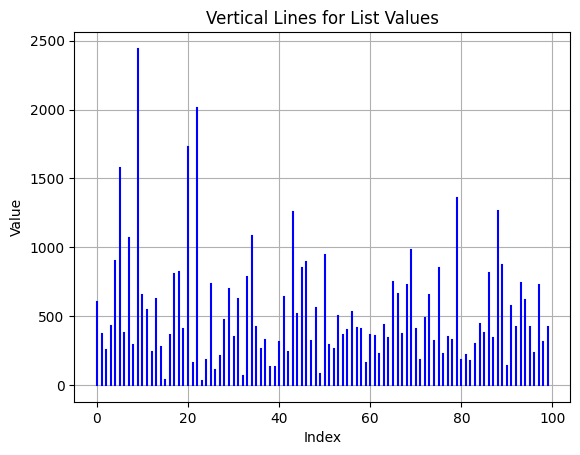

In [18]:
import matplotlib.pyplot as plt 

data = chunkSizes

x = range(len(data))

for i, value in enumerate(data):
    plt.plot([i,i], [0,value], 'b-')
    
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Vertical Lines for List Values')
plt.grid(True)

plt.show()

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [19]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [20]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [21]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [22]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model = "gpt-4.1-nano")



In [23]:
from langchain.chat_models import ChatOpenAI
from langchain.callbacks.tracers.langchain import LangChainTracer
from langchain.callbacks.manager import CallbackManager

def make_chat_model(retriever_name: str = None, model_name: str = "gpt-4o") -> ChatOpenAI:
    if retriever_name:
        tracer = LangChainTracer(
            project_name=f"ragas-eval-{retriever_name}",
            tags=[retriever_name, "retriever", "session-13", model_name]
        )
        callback_manager = CallbackManager([tracer])
        return ChatOpenAI(
            model=model_name,
            temperature=0,
            max_tokens=8192,
            callback_manager=callback_manager
        )
    else:
        return ChatOpenAI(
            model=model_name,
            temperature=0,
            max_tokens=1024
        )

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [24]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

chat_model = make_chat_model()
naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\1280805969.py:19: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  return ChatOpenAI(


Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [25]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked "John Wick." The reviews for the first film are mostly positive, with high ratings and praise for its action sequences, style, and Keanu Reeves\' performance. While there are a few mixed opinions, the overall sentiment is that "John Wick" is a well-received action film that stands out in its genre.'

In [26]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [John Wick 3 Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [27]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, is a retired hitman who is mourning the recent death of his wife. His life takes a violent turn when a young Russian-American gangster, who is unaware of Wick\'s lethal past, steals his car and kills his dog, a final gift from his late wife. This act of violence pulls Wick back into the world of assassination as he seeks revenge against those who wronged him. The film is known for its intense action sequences, stylish stunts, and the portrayal of a criminal underworld where Wick is both feared and respected. As Wick embarks on his quest for vengeance, he becomes the target of numerous assassins, leading to a series of brutal confrontations.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [28]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [29]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [30]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, opinions on the John Wick movies appear to be mixed. Some reviews are very positive, praising the action sequences, style, and simplicity of the plot, particularly for the first movie. For example, one review describes "John Wick 1" as a "must see for action fans" and gives it a high rating. However, there are also negative reviews, particularly for the later movies in the series, such as "John Wick 3" and "John Wick 4," which are criticized for being overly violent, lacking plot, and being less engaging. Therefore, while some people generally liked John Wick, especially the first film, others did not enjoy the later installments as much.'

In [31]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided context, there are no reviews with a rating of 10.'

In [32]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'I don\'t know what specifically happened in "John Wick" based on the provided context. The context includes reviews of the John Wick series, but it does not provide a detailed plot summary of the first movie.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [33]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [34]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [35]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked the first "John Wick" film. The reviews highlight the film\'s unique style, impressive action sequences, and Keanu Reeves\' performance. The film is described as "the coolest action film you\'ll see all year" and "something special," with high ratings of 9 and 10 from the reviewers. The positive feedback suggests that the film was well-received by audiences, particularly those who enjoy action movies.'

In [36]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: [Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

In [37]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, is an ex-hitman who comes out of retirement to seek revenge on the gangsters who killed his dog and stole his car. The dog was a final gift from his recently deceased wife, and its death pushes him to return to his violent past. As he seeks vengeance, he becomes the target of numerous hitmen, as there is a large bounty on his head. The film is known for its intense action sequences and the portrayal of John Wick as a relentless and skilled assassin.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [38]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [39]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [40]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that the "John Wick" series is generally well-received by audiences. Many reviews highlight the films\' action sequences, stylish presentation, and Keanu Reeves\' performance. The first film, in particular, is praised for its unique approach to the action genre. However, there are some mixed reviews, especially for the later installments, with some viewers feeling that the series became too over-the-top or repetitive. Overall, the series appears to have a strong fan base and is generally liked, but not universally loved by everyone.'

In [41]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: [/review/rw4854296/?ref_=tt_urv](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

In [42]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the plot revolves around the character John Wick, played by Keanu Reeves, who is a retired hitman. The story begins with John grieving the loss of his wife. After her death, he receives a puppy as a final gift from her, which becomes a symbol of hope and a reason to continue living. However, his life takes a violent turn when a group of Russian gangsters, led by a young punk, break into his home, steal his car, and kill his dog. This brutal act of violence pulls John Wick out of retirement, and he embarks on a relentless quest for revenge against those who wronged him. The film is known for its stylish action sequences, choreographed stunts, and the portrayal of a criminal underworld where John Wick is both feared and respected.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [43]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [44]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [45]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [46]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [47]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [48]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that opinions on the John Wick series are mixed. Some people, like the reviewer "jtindahouse," found "John Wick: Chapter 4" to be the best in the series and praised it highly. On the other hand, another reviewer, "solidabs," had a very negative opinion of the same movie, describing it as "horrible" and criticizing various aspects of it. Additionally, a review of the first John Wick movie by "MrHeraclius" was very positive, highlighting the action and emotional setup.\n\nOverall, while there are some negative opinions, there are also very positive ones, suggesting that many people generally liked the John Wick series. However, as with any movie, individual opinions can vary widely.'

In [49]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv.'

In [50]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the first "John Wick" movie, John Wick, played by Keanu Reeves, is a retired hitman who comes out of retirement to seek vengeance after gangsters kill his dog and steal his car. The dog was a final gift from his recently deceased wife, and its death pushes him to unleash a wave of violence against those responsible. The movie is filled with action, shootouts, and fights as Wick takes on an army of bounty hunters and killers.\n\nIn "John Wick: Chapter 2," the story continues with Wick trying to retrieve his stolen car. However, he is pulled back into the world of assassins when he is forced to repay an old debt. This leads him to travel to various locations, including Italy, Canada, and Manhattan, where he faces numerous assassins. The sequel is noted for its intense action and is considered by some to be better than the original.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [51]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [52]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [53]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked "John Wick." The reviews highlight the film\'s action sequences, Keanu Reeves\' performance, and the unique style of the movie. Many reviewers gave high ratings and praised the film for its entertainment value and action choreography. However, there are a few mixed reviews, with some viewers not understanding the widespread acclaim or finding certain aspects of the sequels less appealing. Overall, the positive reviews suggest that "John Wick" was well-received by many.'

In [54]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: [/review/rw4854296/?ref_=tt_urv](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

In [55]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the plot revolves around the titular character, played by Keanu Reeves, who is a retired hitman. The story begins with John Wick grieving the recent death of his beloved wife. She had arranged for a puppy to be delivered to him after her death to help him cope with his loss. However, his life takes a violent turn when a group of Russian gangsters, led by a young punk, break into his home, steal his car, and kill his dog. This act of violence pulls John Wick out of retirement as he seeks revenge against those who wronged him. The film is known for its intense action sequences, stylish stunts, and the portrayal of John Wick as a legendary and nearly unstoppable assassin. The movie is essentially about John Wick\'s quest for vengeance against the Russian mobsters who took away the last connection he had to his late wife.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [56]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [57]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

Let's create a new vector store.

In [58]:
semantic_documents = semantic_chunker.split_documents(documents)

In [59]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [60]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [61]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [62]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the context provided, it seems that people generally liked the John Wick series. The reviews for the first film are particularly positive, with high ratings and praise for its action sequences, style, and Keanu Reeves' performance. While there are some mixed reviews for the third film, the overall sentiment across the series appears to be favorable, with the fourth installment also receiving positive feedback."

In [63]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv.'

In [64]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, played by Keanu Reeves, is a retired assassin who comes out of retirement to seek revenge on the people who wronged him. The story begins with the untimely death of his beloved wife, after which he receives a puppy as a final gift from her. However, a group of thugs, led by the son of a Russian gangster, break into his house, beat him up, steal his car, and kill the puppy. This act of violence prompts John Wick to embark on a relentless quest for vengeance against those responsible, leading to a series of intense and stylish action sequences. The film is known for its kinetic action, stylish stunts, and the portrayal of a criminal underworld where John Wick wages a one-man war against the Russian Mafia.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [65]:
#
docs = documents

In [66]:

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model = 'text-embedding-3-small'))


In [67]:
from ragas.testset import TestsetGenerator
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

dataset.to_pandas()

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 99baba2e-db05-43ed-9cb6-c8ee95d81b95 does not have a summary. Skipping filtering.
Node f24b2e0c-5bd6-4e80-b8d9-b3742e13a6ba does not have a summary. Skipping filtering.
Node 5eeb75a4-f6a7-486b-b6f6-c5249166c369 does not have a summary. Skipping filtering.
Node c229d3ba-6f01-43f8-b6a6-33db96295a13 does not have a summary. Skipping filtering.
Node 0c7f0e3e-0d92-4cdc-a749-eea344898d6a does not have a summary. Skipping filtering.
Node ef946782-4208-4c31-9971-b8c2f5fa16ab does not have a summary. Skipping filtering.
Node c6764fb9-ea53-4001-9f92-5596c5226b1b does not have a summary. Skipping filtering.
Node f288c5b9-4969-44f8-b482-074254d19c8e does not have a summary. Skipping filtering.
Node 8cf9b47d-71d7-4955-8c8b-ab49b9b15d8c does not have a summary. Skipping filtering.
Node 118344a2-99c1-4494-9f5b-678f3f41f03c does not have a summary. Skipping filtering.
Node b70cef0e-a38e-4190-8f74-227df63461b0 does not have a summary. Skipping filtering.
Node 2b7f8e74-b753-496a-a250-6c1fe927a60d d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/220 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Who is John Wick in the action movie?,[: 0\nReview: The best way I can describe John...,John Wick is a character played by Keanu Reeve...,single_hop_specifc_query_synthesizer
1,Why is John Wick so popular?,[: 2\nReview: With the fourth installment scor...,The context indicates that the reviewer decide...,single_hop_specifc_query_synthesizer
2,Who is Chad Stahelski and what is his role in ...,[: 3\nReview: John wick has a very simple reve...,"Chad Stahelski is the director of John Wick, a...",single_hop_specifc_query_synthesizer
3,Who is John Wick?,[: 4\nReview: Though he no longer has a taste ...,"John Wick is a retired assassin and ""Boogeyman...",single_hop_specifc_query_synthesizer
4,How does the story complexity and character de...,"[<1-hop>\n\n: 21\nReview: Wow, this is one of ...","The first John Wick movie had a clear story, p...",multi_hop_abstract_query_synthesizer
5,john wick review how it like takin and john wi...,"[<1-hop>\n\n: 9\nReview: At first glance, John...",john wick review says it like takin and is a r...,multi_hop_abstract_query_synthesizer
6,How does the second John Wick movie show hardc...,[<1-hop>\n\n: 8\nReview: In this 2nd installme...,The second John Wick movie features hardcore a...,multi_hop_abstract_query_synthesizer
7,How does the recognition of stunt talent in Jo...,[<1-hop>\n\n: 16\nReview: John Wick 3 is witho...,"In John Wick 3, the recognition of stunt talen...",multi_hop_abstract_query_synthesizer
8,how does the matrix relate to john wick and wh...,[<1-hop>\n\n: 7\nReview: John Wick (2014) is t...,the context shows that john wick is directed b...,multi_hop_specific_query_synthesizer
9,Russian mobster kill dog and car and Wick reve...,[<1-hop>\n\n: 5\nReview: Ultra-violent first e...,"In the story, after Wick's dog is killed and h...",multi_hop_specific_query_synthesizer


In [68]:
valid_samples = [s for s in dataset.samples if s.eval_sample.reference is not None]

# print the testset (Question and Grounded Truth)
for sample in dataset.samples:
    print("Q:", sample.eval_sample.user_input)
    print("GT:", sample.eval_sample.reference)
    print("—" * 60)

Q: Who is John Wick in the action movie?
GT: John Wick is a character played by Keanu Reeves who seeks revenge after someone takes something he loves, specifically his dog. The movie is known for its awesome action, stylish stunts, and kinetic chaos, with John Wick serving as a relatable hero.
————————————————————————————————————————————————————————————
Q: Why is John Wick so popular?
GT: The context indicates that the reviewer decided to check out "John Wick" after the success of the previous films, which are apparently loved by everyone else in the world. This suggests that John Wick is popular due to its widespread acclaim and the appeal of its intense action and formidable characters.
————————————————————————————————————————————————————————————
Q: Who is Chad Stahelski and what is his role in the John Wick movie?
GT: Chad Stahelski is the director of John Wick, and he is a stunt specialist whose expertise is evident in the film's virtuoso action sequences and well-made choreographi

In [69]:
import time

def safe_generate(llm, question, retries=3, delay=2):
    for attempt in range(retries):
        try:
            result = llm.invoke(question)
            return result.content if hasattr(result, "content") else str(result)
        except Exception as e:
            print(f"⚠️ Retry {attempt+1} for generation failed: {e}")
            time.sleep(delay)
    return "Generation failed"

In [70]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
)


def evaluate_per_sample(samples, retriever, llm, embeddings, name="naive", sleep=3):
    scores = {
        "answer_correctness": [],
        "answer_relevancy": [],
        "faithfulness": [],
        "context_recall": [],
        "context_precision": [],
    }

    for i, sample in enumerate(samples, 1):
        question = sample.eval_sample.user_input
        ground_truth = sample.eval_sample.reference

        docs = retriever.get_relevant_documents(question)
        contexts = [doc.page_content for doc in docs]
        
        # Use safe LLM generation
        answer = safe_generate(llm, question)
        
        eval_ds = Dataset.from_dict({
            "question": [question],
            "contexts": [contexts],
            "answer": [answer],
            "ground_truth": [ground_truth],
        })

        try:
            result = evaluate(
                dataset=eval_ds,
                metrics=[
                    answer_relevancy,
                    faithfulness,
                    context_recall,
                    context_precision,
                    answer_correctness,
                ],
                llm=llm,
                embeddings=embeddings
            )
            for k in scores:
                scores[k].append(result[k])
            print(f"[{name}] ✅ {i}/{len(samples)} complete")
        except Exception as e:
            print(f"[{name}] ❌ {i}/{len(samples)} failed: {e}")
            for k in scores:
                scores[k].append(None)

        time.sleep(sleep)  # ⏱️ Control rate limit manually

    return scores

In [71]:
import numpy as np
import pandas as pd

def summarize_scores(scores_dict, name="Naive"):
    summary = {k: round(np.nanmean([v for v in values if v is not None]), 4)
               for k, values in scores_dict.items()}
    return pd.DataFrame([summary], index=[name])

In [72]:
retrievers = {
    "naive": naive_retriever,
    "bm25": bm25_retriever,
    "compression": compression_retriever,
    "multi_query": multi_query_retriever,
    "parent": parent_document_retriever,
    "ensemble": ensemble_retriever,
    "semantic": semantic_retriever,
}

In [73]:
all_scores = {}
all_dataframes = []

for retriever_name, retriever in retrievers.items():
    print(f"\n🔍 Evaluating retriever: {retriever_name}")

    scores = evaluate_per_sample(
        samples=valid_samples,
        retriever=retriever,
        llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),
        embeddings=embeddings,
        name=retriever_name,
        sleep=4
    )

    # Store scores and summarized DataFrame
    all_scores[retriever_name] = scores
    df = summarize_scores(scores, name=retriever_name.capitalize())
    all_dataframes.append(df)


🔍 Evaluating retriever: naive


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),
C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\2877002052.py:25: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 12/12 complete

🔍 Evaluating retriever: bm25


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 12/12 complete

🔍 Evaluating retriever: compression


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 12/12 complete

🔍 Evaluating retriever: multi_query


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 12/12 complete

🔍 Evaluating retriever: parent


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 12/12 complete

🔍 Evaluating retriever: ensemble


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 12/12 complete

🔍 Evaluating retriever: semantic


C:\Users\bsmith53\AppData\Local\Temp\ipykernel_6068\4231787146.py:10: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 12/12 complete


In [74]:
final_df = pd.concat(all_dataframes, axis=0)

print(final_df)

             answer_correctness  answer_relevancy  faithfulness  \
Naive                    0.4349            0.8002        0.6103   
Bm25                     0.4071            0.8162        0.3214   
Compression              0.3975            0.8053        0.3559   
Multi_query              0.4098            0.8083        0.6259   
Parent                   0.3851            0.8120        0.2566   
Ensemble                 0.3989            0.8071        0.5786   
Semantic                 0.4217            0.8097        0.5222   

             context_recall  context_precision  
Naive                0.7917             0.7654  
Bm25                 0.5069             0.4977  
Compression          0.7500             0.8611  
Multi_query          0.7917             0.7654  
Parent               0.5764             0.5903  
Ensemble             0.8333             0.6121  
Semantic             0.8333             0.6364  


In [75]:
from langsmith import Client

def get_langsmith_metrics(project_name, model_name="gpt-4o"):
    client = Client()
    runs = list(client.list_runs(project_name=project_name, run_type="llm"))

    latencies = []
    costs = []

    for run in runs:
        full_run = client.read_run(run.id)

        if full_run.start_time and full_run.end_time:
            duration = (full_run.end_time - full_run.start_time).total_seconds()
            latencies.append(duration)

        usage = (
            full_run.outputs
            .get("llm_output", {})
            .get("token_usage", {})
        )

        input_tokens = usage.get("prompt_tokens", 0)
        output_tokens = usage.get("completion_tokens", 0)

        if "gpt-4o" in model_name:
            cost = (input_tokens / 1000) * 0.005 + (output_tokens / 1000) * 0.015
        elif "gpt-3.5" in model_name:
            cost = (input_tokens / 1000) * 0.0015 + (output_tokens / 1000) * 0.002
        else:
            cost = 0

        costs.append(cost)

    avg_latency = round(sum(latencies) / len(latencies), 3) if latencies else None
    total_cost = round(sum(costs), 4) if costs else None

    return avg_latency, total_cost

In [76]:
#client = Client()
#print(client.get_projects())

In [77]:
latencies = []
costs = []



for name in retrievers.keys():
    project_name = f"ragas-eval-{name}"
    print("Processing tracing information for", project_name)
    latency, cost = get_langsmith_metrics(project_name)
    latencies.append(latency)
    costs.append(cost)

final_df["avg_latency_s"] = latencies
final_df["total_cost_usd"] = costs

Processing tracing information for ragas-eval-naive
Processing tracing information for ragas-eval-bm25
Processing tracing information for ragas-eval-compression
Processing tracing information for ragas-eval-multi_query
Processing tracing information for ragas-eval-parent
Processing tracing information for ragas-eval-ensemble
Processing tracing information for ragas-eval-semantic


In [78]:
print("Latency Values: ", latencies)
print("Cost Values: ", costs)

print(final_df)

Latency Values:  [7.014, 7.978, 8.277, 8.395, 8.387, 7.046, 7.595]
Cost Values:  [0.055, 0.0573, 0.0576, 0.0583, 0.0629, 0.0604, 0.0543]
             answer_correctness  answer_relevancy  faithfulness  \
Naive                    0.4349            0.8002        0.6103   
Bm25                     0.4071            0.8162        0.3214   
Compression              0.3975            0.8053        0.3559   
Multi_query              0.4098            0.8083        0.6259   
Parent                   0.3851            0.8120        0.2566   
Ensemble                 0.3989            0.8071        0.5786   
Semantic                 0.4217            0.8097        0.5222   

             context_recall  context_precision  avg_latency_s  total_cost_usd  
Naive                0.7917             0.7654          7.014          0.0550  
Bm25                 0.5069             0.4977          7.978          0.0573  
Compression          0.7500             0.8611          8.277          0.0576  
Multi_

In [80]:
from tabulate import tabulate

# switch the columns and the rows so that the metrics are the rows and the retrievers are the columns.
final_df = final_df.T

# Define groups
retriever_metrics = ["context_precision", "context_recall", "faithfulness"]
answer_metrics = ["answer_relevancy", "answer_correctness"]
infra_metrics = ["avg_latency_s", "total_cost_usd"]

# Reorder with blank rows as visual separators
ordered_rows = (
    retriever_metrics +
    answer_metrics +
    infra_metrics
)

# Reindex with visual grouping
df_grouped = final_df.reindex(ordered_rows)

# Add a "Group" column for display/printing
group_labels = {
    "context_precision": "Retriever",
    "context_recall": "Retriever",
    "faithfulness": "Retriever",
    "answer_relevancy": "Answer",
    "answer_correctness": "Answer",
    "avg_latency_s": "Infra",
    "total_cost_usd": "Infra",
}

df_grouped.insert(0, "Group", [group_labels.get(m, "") for m in df_grouped.index])


print(tabulate(df_grouped, headers="keys", tablefmt="grid"))

+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
|                    | Group     |   Naive |   Bm25 |   Compression |   Multi_query |   Parent |   Ensemble |   Semantic |
+====================+===========+=========+========+===============+===============+==========+============+============+
| context_precision  | Retriever |  0.7654 | 0.4977 |        0.8611 |        0.7654 |   0.5903 |     0.6121 |     0.6364 |
+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
| context_recall     | Retriever |  0.7917 | 0.5069 |        0.75   |        0.7917 |   0.5764 |     0.8333 |     0.8333 |
+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
| faithfulness       | Retriever |  0.6103 | 0.3214 |        0.3559 |        0.6259 |   0.2566 |     0.5786 |     0.5222 |
+---------------